In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
from tqdm.auto import tqdm
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb


c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import glob
import os

# Data Loading

In [5]:
from pathlib import Path

# Check if /kaggle/input exists to determine if running on Kaggle
if os.path.exists("/kaggle/input"):
    # On Kaggle notebook
    DATA_DIR = Path("/kaggle/input/nfl-big-data-bowl-2026-prediction")
else:
    # On local PC
    DATA_DIR = Path("nfl-big-data-bowl-2026-prediction")

# DATA_DIR = Path("nfl-big-data-bowl-2026-prediction")

# Load all CSV files from train folder
train_input_files = sorted(glob.glob(str(DATA_DIR /'train'/'input_*.csv')))
train_output_files = sorted(glob.glob(str(DATA_DIR /'train'/'output_*.csv')))

print(f'Input files: {len(train_input_files)}')
print(f'Output files: {len(train_output_files)}')

Input files: 18
Output files: 18


# Data Preprocessing

In [6]:
# Combine data
input_dfs = []
output_dfs = []

for input_file, output_file in zip(train_input_files, train_output_files):
    input_df = pd.read_csv(input_file)
    output_df = pd.read_csv(output_file)
    input_dfs.append(input_df)
    output_dfs.append(output_df)

train_input = pd.concat(input_dfs, ignore_index=True)
train_output = pd.concat(output_dfs, ignore_index=True)

print(f'Train input shape: {train_input.shape}')
print(f'Train output shape: {train_output.shape}')

Train input shape: (4880579, 23)
Train output shape: (562936, 6)


In [7]:
# Data Inspection
print("Input columns:")
print(train_input.columns.tolist())
print("\nOutput columns:")
print(train_output.columns.tolist())
print("\nInput sample:")
display(train_input.head())
print("\nOutput sample:")
display(train_output.head())

Input columns:
['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id', 'play_direction', 'absolute_yardline_number', 'player_name', 'player_height', 'player_weight', 'player_birth_date', 'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a', 'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y']

Output columns:
['game_id', 'play_id', 'nfl_id', 'frame_id', 'x', 'y']

Input sample:


,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.09,0.39,322.40,238.24,21,63.259998,-0.22
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.04,0.61,200.89,236.05,21,63.259998,-0.22
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.93,0.12,0.73,147.55,240.60,21,63.259998,-0.22
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.35,36.92,0.23,0.81,131.40,244.25,21,63.259998,-0.22
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.37,36.90,0.35,0.82,123.26,244.25,21,63.259998,-0.22



Output sample:


,game_id,play_id,nfl_id,frame_id,x,y
0,2023090700,101,46137,1,56.22,17.28
1,2023090700,101,46137,2,56.63,16.88
2,2023090700,101,46137,3,57.06,16.46
3,2023090700,101,46137,4,57.48,16.02
4,2023090700,101,46137,5,57.91,15.56


In [8]:
# Filter only players to predict
train_input_filtered = train_input[train_input['player_to_predict'] == True].copy()
print(f'Filtered input shape: {train_input_filtered.shape}')

Filtered input shape: (1303440, 23)


In [9]:
# Merge input and output data
merged_data = train_input_filtered.merge(
    train_output,
    on=['game_id', 'play_id', 'nfl_id', 'frame_id'],
    suffixes=('_input', '_output')
)

print(f'Merged data shape: {merged_data.shape}')

# --- Start of Play Direction Standardization ---
print("Standardizing play direction...")

# Create a mask for 'left' plays
left_mask = merged_data['play_direction'] == 'left'

# Flip x coordinates (120 yard field)
merged_data.loc[left_mask, 'x_input'] = 120.0 - merged_data.loc[left_mask, 'x_input']
merged_data.loc[left_mask, 'ball_land_x'] = 120.0 - merged_data.loc[left_mask, 'ball_land_x']
merged_data.loc[left_mask, 'x_output'] = 120.0 - merged_data.loc[left_mask, 'x_output'] # Flip target

# Flip y coordinates (53.3 yard field width)
merged_data.loc[left_mask, 'y_input'] = 53.3 - merged_data.loc[left_mask, 'y_input']
merged_data.loc[left_mask, 'ball_land_y'] = 53.3 - merged_data.loc[left_mask, 'ball_land_y']
merged_data.loc[left_mask, 'y_output'] = 53.3 - merged_data.loc[left_mask, 'y_output'] # Flip target

# Flip orientation and direction angles
merged_data.loc[left_mask, 'o'] = (merged_data.loc[left_mask, 'o'] + 180) % 360
merged_data.loc[left_mask, 'dir'] = (merged_data.loc[left_mask, 'dir'] + 180) % 360

print("Play direction standardized. All plays now effectively move 'right'.")
# --- End of Play Direction Standardization ---

display(merged_data.head())

Merged data shape: (560426, 25)
Standardizing play direction...
Play direction standardized. All plays now effectively move 'right'.


,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,y_input,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y,x_output,y_output
0,2023090700,101,True,46137,1,right,42,Justin Reid,6-1,204,...,20.69,0.31,0.49,79.43,267.68,21,63.259998,-0.22,56.22,17.28
1,2023090700,101,True,46137,2,right,42,Justin Reid,6-1,204,...,20.66,0.36,0.74,118.07,268.66,21,63.259998,-0.22,56.63,16.88
2,2023090700,101,True,46137,3,right,42,Justin Reid,6-1,204,...,20.63,0.44,0.76,130.89,269.78,21,63.259998,-0.22,57.06,16.46
3,2023090700,101,True,46137,4,right,42,Justin Reid,6-1,204,...,20.61,0.48,0.62,134.50,269.78,21,63.259998,-0.22,57.48,16.02
4,2023090700,101,True,46137,5,right,42,Justin Reid,6-1,204,...,20.58,0.54,0.44,129.79,269.06,21,63.259998,-0.22,57.91,15.56


# Feature selection 

In [10]:
def height_to_inches(h):
    """Converts height string (e.g., "6-1") to inches."""
    try:
        f, i = str(h).split("-")
        return int(f) * 12 + int(i)
    except:
        return np.nan

def create_advanced_features(df):
    """
    Create comprehensive feature set for optimal prediction.
    MODIFIED: Uses 'x_input' and 'y_input' for player's current position.
    """
    df = df.copy()

    # Ball-related features
    # Use x_input and y_input for player position
    df['dist_to_ball_land'] = np.sqrt(
        (df['x_input'] - df['ball_land_x'])**2 +
        (df['y_input'] - df['ball_land_y'])**2
    )

    df['angle_to_ball'] = np.arctan2(
        df['ball_land_y'] - df['y_input'],
        df['ball_land_x'] - df['x_input']
    )

    df['angle_to_ball_deg'] = np.degrees(df['angle_to_ball'])

    df['speed_to_ball'] = df['s'] * np.cos(
        np.radians(df['dir']) - df['angle_to_ball']
    )

    df['delta_x_to_ball'] = df['ball_land_x'] - df['x_input']
    df['delta_y_to_ball'] = df['ball_land_y'] - df['y_input']
    df['manhattan_dist_to_ball'] = np.abs(df['delta_x_to_ball']) + np.abs(df['delta_y_to_ball'])
    df['eucl_dist_to_ball'] = np.sqrt((df['ball_land_x'] - df['x_input'])**2 + (df['ball_land_y'] - df['y_input'])**2)
    df['x_y_dist_ratio'] = np.abs(df['delta_x_to_ball']) / (np.abs(df['delta_y_to_ball']) + 0.1)

    # Role encoding
    role_map = {
        'Targeted Receiver': 4,
        'Defensive Coverage': 3,
        'Other Route Runner': 2,
        'Passer': 1
    }
    df['role_encoded'] = df['player_role'].map(role_map).fillna(0)

    df['is_offense'] = (df['player_side'] == 'Offense').astype(int)
    df['is_targeted'] = (df['player_role'] == 'Targeted Receiver').astype(int)
    df['is_defender'] = (df['player_role'] == 'Defensive Coverage').astype(int)
    df['is_passer'] = (df['player_role'] == 'Passer').astype(int)

    # Field position
    df['field_position'] = df['absolute_yardline_number']
    df['play_dir_encoded'] = (df['play_direction'] == 'right').astype(int)

    df['dist_from_left_sideline'] = df['y_input']
    df['dist_from_right_sideline'] = 53.3 - df['y_input']
    df['dist_from_nearest_sideline'] = np.minimum(
        df['dist_from_left_sideline'],
        df['dist_from_right_sideline']
    )
    df['dist_from_endzone'] = np.minimum(df['x_input'], 120 - df['x_input'])

    # Velocity and acceleration components
    df['vx'] = df['s'] * np.cos(np.radians(df['dir']))
    df['vy'] = df['s'] * np.sin(np.radians(df['dir']))
    df['ax'] = df['a'] * np.cos(np.radians(df['dir']))
    df['ay'] = df['a'] * np.sin(np.radians(df['dir']))
    df['speed_squared'] = df['s'] ** 2
    df['accel_squared'] = df['a'] ** 2

    # Orientation features
    df['orientation_dir_diff'] = np.abs(df['o'] - df['dir'])
    df['orientation_dir_diff'] = np.where(
        df['orientation_dir_diff'] > 180,
        360 - df['orientation_dir_diff'],
        df['orientation_dir_diff']
    )
    df['facing_ball'] = (df['orientation_dir_diff'] < 90).astype(int)

    # Physics-based features
    df['expected_time_to_ball'] = df['dist_to_ball_land'] / (df['s'] + 0.1)
    df['frames_after_ball'] = df['num_frames_output'] - (df['expected_time_to_ball'] * 10)

    df['estimated_x_next'] = df['x_input'] + df['vx'] * 0.1
    df['estimated_y_next'] = df['y_input'] + df['vy'] * 0.1
    df['estimated_x_1sec'] = df['x_input'] + df['vx']
    df['estimated_y_1sec'] = df['y_input'] + df['vy']

    df['can_reach_ball'] = (df['expected_time_to_ball'] < df['num_frames_output'] * 0.1).astype(int)

    # Kinetic energy proxy
    df['kinetic_energy'] = 0.5 * df['speed_squared']

    # Trajectory curvature proxy
    df['velocity_angle'] = np.arctan2(df['vy'], df['vx'])
    df['trajectory_alignment'] = np.abs(df['velocity_angle'] - df['angle_to_ball'])

    return df
     
def add_sequence_features(df, window=3):
    """Add temporal sequence features"""
    df = df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id'])

    # Velocity changes
    df['delta_vx'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['vx'].diff()
    df['delta_vy'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['vy'].diff()
    df['delta_speed'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['s'].diff()

    # Acceleration changes (jerk)
    df['delta_ax'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['ax'].diff()
    df['delta_ay'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['ay'].diff()

    # Rolling statistics
    for col in ['s', 'a', 'vx', 'vy']:
        df[f'{col}_rolling_mean'] = df.groupby(['game_id', 'play_id', 'nfl_id'])[col].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        df[f'{col}_rolling_std'] = df.groupby(['game_id', 'play_id', 'nfl_id'])[col].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )

    df.fillna(0, inplace=True)

    return df
     
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """Wrapper function to apply all feature engineering steps."""
    df = create_advanced_features(df)
    df = add_sequence_features(df)
    return df

# %%
# --- Apply New Feature Engineering Pipeline ---
print("Applying new feature engineering pipeline...")
merged_data = engineer_features(merged_data)

# --- Apply Post-Engineering Steps from User Snippet ---
merged_data["player_height"] = merged_data["player_height"].apply(height_to_inches)

# One-hot encode position and role
position_dummies = pd.get_dummies(merged_data["player_position"], prefix="position")
role_dummies = pd.get_dummies(merged_data["player_role"], prefix="role")

merged_data = pd.concat([
    merged_data,
    position_dummies,
    role_dummies
], axis=1)

# --- Define Feature and Target Columns ---

# This list is from your provided code
feature_cols = [
    'absolute_yardline_number', 'player_weight', 'x_input', 'y_input', 's', 'a',
    'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y',
    'dist_to_ball_land', 'angle_to_ball', 'angle_to_ball_deg',
    'speed_to_ball', 'delta_x_to_ball', 'delta_y_to_ball',
    'manhattan_dist_to_ball', 'x_y_dist_ratio',
    'is_offense', 'is_targeted', 'is_defender', 'is_passer',
    'field_position', 'play_dir_encoded', 'dist_from_left_sideline',
    'dist_from_right_sideline', 'dist_from_nearest_sideline',
    'dist_from_endzone', 'vx', 'vy', 'ax', 'ay', 'speed_squared',
    'accel_squared', 'orientation_dir_diff', 'facing_ball',
    'expected_time_to_ball', 'frames_after_ball', 'estimated_x_next',
    'estimated_y_next', 'estimated_x_1sec', 'estimated_y_1sec',
    'can_reach_ball', 'kinetic_energy', 'velocity_angle',
    'trajectory_alignment', 'delta_vx', 'delta_vy', 'delta_speed',
    'delta_ax', 'delta_ay', 's_rolling_mean', 's_rolling_std',
    'a_rolling_mean', 'a_rolling_std', 'vx_rolling_mean', 'vx_rolling_std',
    'vy_rolling_mean', 'vy_rolling_std'
]
# Add all the one-hot encoded columns automatically
feature_cols.extend(position_dummies.columns.tolist())
feature_cols.extend(role_dummies.columns.tolist())

# Remove duplicates just in case
feature_cols = list(dict.fromkeys(feature_cols)) 

# Create final X and y
X = merged_data[feature_cols].fillna(0)
y = merged_data[["x_output","y_output"]]

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')
print(f"Total features: {len(feature_cols)}")


Applying new feature engineering pipeline...
Features shape: (560426, 79)
Target shape: (560426, 2)
Total features: 79


# Data Split for training and testing

In [12]:
y_np = y.values
X_train, X_test, y_train, y_test = train_test_split(
    X, y_np, test_size=0.3, random_state=0
)

print(f'Training set size: {X_train.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')
print(f'Target shape: {y_train.shape} (samples, [x, y])')

Training set size: 392298
Test set size: 168128
Target shape: (392298, 2) (samples, [x, y])


# Model Training

In [13]:
lgbm_nfl = LGBMRegressor(n_estimators=100,
                         random_state=0, n_jobs=-1)
multi_output_booster = MultiOutputRegressor(estimator=lgbm_nfl)
multi_output_booster.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12916
[LightGBM] [Info] Number of data points in the train set: 392298, number of used features: 76
[LightGBM] [Info] Start training from score 69.440248
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12916
[LightGBM] [Info] Number of data points in the train set: 392298, number of used features: 76
[LightGBM] [Info] Start training from score 26.503093


,estimator,LGBMRegressor...andom_state=0)
,n_jobs,None
,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0


# Model Evaluation : Assessing Test and Training Data

In [14]:
# Predict on training and test data
y_hat_train = multi_output_booster.predict(X_train)
y_hat_test = multi_output_booster.predict(X_test)

# Calculate MSE
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print(f"Training Mean Squared Error (MSE): {train_mse}")
print(f"Test Mean Squared Error (MSE): {test_mse}")

# You can also calculate MSE per output (x and y)
train_mse_x = mean_squared_error(y_train[:, 0], y_hat_train[:, 0])
train_mse_y = mean_squared_error(y_train[:, 1], y_hat_train[:, 1])
test_mse_x = mean_squared_error(y_test[:, 0], y_hat_test[:, 0])
test_mse_y = mean_squared_error(y_test[:, 1], y_hat_test[:, 1])

print(f"\nTest MSE for X: {test_mse_x}")
print(f"Test MSE for Y: {test_mse_y}")

Training Mean Squared Error (MSE): 11.618091155512245
Test Mean Squared Error (MSE): 11.931970784878944

Test MSE for X: 11.607209359019409
Test MSE for Y: 12.256732210738388


# Importance of features

In [16]:
# 1. Extract the feature importances from each fitted LGBM model
all_importances = [
    estimator.feature_importances_ for estimator in multi_output_booster.estimators_
]

# 2. Average the importances from the 'x' model and 'y' model
average_importances = np.mean(all_importances, axis=0)

# 3. Create the DataFrame using the averaged importances
feature_names = X_train.columns.tolist()
feature_imp = pd.DataFrame(
    {'importance': average_importances},
    index=feature_names
)

# 4. Sort and display the results
print(feature_imp.sort_values(by='importance', ascending=False))

                         importance
num_frames_output             344.0
ball_land_y                   236.0
ball_land_x                   194.0
delta_x_to_ball               133.5
is_offense                    123.0
...                             ...
angle_to_ball_deg               0.0
dist_from_left_sideline         0.0
field_position                  0.0
is_passer                       0.0
role_Targeted Receiver          0.0

[79 rows x 1 columns]


In [17]:
y_hat_boost = multi_output_booster.predict(X_test)

mse = np.mean((y_test - y_hat_boost)**2)

print(f"Mean Squared Error: {mse}")

Mean Squared Error: 11.9319707848789


# Data Visualisation of One tree

<Figure size 2500x2000 with 0 Axes>

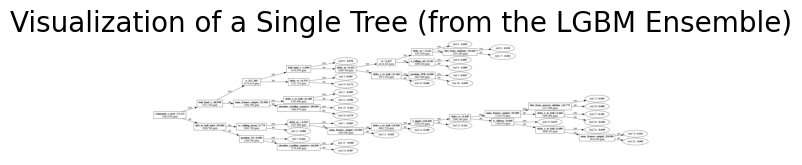

In [18]:

# 1. Get the LGBM model for the first output (the x-coordinate)
lgbm_for_first_output = multi_output_booster.estimators_[0]

# 2. Use lgb.plot_tree() to visualize one of the trees.
#    Let's plot the 50th tree (tree_index=49).
#    Note: LGBM models are sequential, so later trees can be interesting.
plt.figure(figsize=(25, 20))
lgb.plot_tree(lgbm_for_first_output, 
              tree_index=49,  # Pick which tree from the sequence to plot
              show_info=['split_gain'],
              precision=3)

plt.title("Visualization of a Single Tree (from the LGBM Ensemble)", fontsize=20)
plt.show()

# Submission

In [19]:
# --- Imports and API setup ---
import os
import pandas as pd
import polars as pl
import sys
from pathlib import Path

# 1. Add the evaluation API to the system path
# (Uses the DATA_DIR variable you defined in your "Data Loading" cell)
EVAL_DIR = DATA_DIR / 'kaggle_evaluation'
if str(EVAL_DIR) not in sys.path:
    sys.path.append(str(EVAL_DIR))

# Now these imports will work
import kaggle_evaluation.nfl_inference_server

# --- Prediction Function ---

def predict(test: pl.DataFrame, test_input: pl.DataFrame) -> pl.DataFrame | pd.DataFrame:
    """
    Generates predictions for the test set.
    This function is called by the evaluation API and must return a
    DataFrame in the submission format.
    
    It uses the globally trained 'multi_output_booster', 'feature_cols',
    and the new feature engineering functions.
    """
    print("API: Received prediction request...")
    
    # --- Convert Polars to Pandas ---
    test_input_df = test_input.to_pandas()
    test_df = test.to_pandas()
    
    # 1. Filter only players to predict
    test_input_filtered = test_input_df[test_input_df['player_to_predict'] == True].copy()

    # 2. Rename columns to 'x_input', 'y_input' to match feature function expectations
    test_input_filtered = test_input_filtered.rename(columns={'x': 'x_input', 'y': 'y_input'})

    # 3. REMOVED: Play direction standardization is no longer used.
    
    # 4. Feature Engineering (must match training data)
    print("API: Performing new feature engineering...")
    
    # Apply the same feature engineering pipeline as in training
    # The 'engineer_features' function is defined globally
    test_input_filtered = engineer_features(test_input_filtered)
    
    # Apply height conversion (uses global 'height_to_inches' function)
    test_input_filtered['player_height'] = test_input_filtered['player_height'].apply(height_to_inches)

    # 5. One-hot encode player_position and player_role
    print("API: Applying one-hot encoding...")
    test_position_dummies = pd.get_dummies(test_input_filtered['player_position'], prefix='position')
    test_role_dummies = pd.get_dummies(test_input_filtered['player_role'], prefix='role')
    
    test_features_df = pd.concat([test_input_filtered, test_position_dummies, test_role_dummies], axis=1)

    # 6. Align columns with training features
    # Uses the global 'feature_cols' list defined during training
    print("API: Aligning feature columns...")
    X_test_api = pd.DataFrame(columns=feature_cols)
    
    # Add an empty DataFrame to test_features_df to ensure all columns
    # from feature_cols exist, filling missing ones with NaN
    X_test_api = pd.concat([X_test_api, test_features_df])
    
    # Select only the required feature columns and fill NaNs with 0
    # This handles missing dummy variables and any other NaNs from engineering
    X_test_api = X_test_api[feature_cols].fillna(0)
    
    print(f'API: Test features shape: {X_test_api.shape}')

    # 7. Predict on test data
    print('API: Predicting test data...')
    # Uses the globally trained 'multi_output_booster'
    test_predictions = multi_output_booster.predict(X_test_api)
    test_pred_x = test_predictions[:, 0]
    test_pred_y = test_predictions[:, 1]
    
    # Add predictions back to the filtered dataframe
    test_input_filtered['pred_x'] = test_pred_x
    test_input_filtered['pred_y'] = test_pred_y

    # 8. REMOVED: Inversion of 'left' plays is no longer needed.

    # 9. Format the submission
    submission = test_df.copy()
    
    # Merge predictions
    # We only need the key columns and the new prediction columns
    test_pred_df = test_input_filtered[['game_id', 'play_id', 'nfl_id', 'frame_id', 'pred_x', 'pred_y']].copy()
    
    submission = submission.merge(
        test_pred_df,
        on=['game_id', 'play_id', 'nfl_id', 'frame_id'],
        how='left'
    )
    
    # --- Return only 'x' and 'y' columns ---
    predictions_df = submission[['pred_x', 'pred_y']].rename(columns={'pred_x': 'x', 'pred_y': 'y'})
    
    # Fill any missing predictions (e.g., if a player in test_df wasn't in test_input)
    predictions_df = predictions_df.fillna(0) 
    
    print("API: Prediction request complete.")
    
    # Check assertions
    assert isinstance(predictions_df, (pd.DataFrame, pl.DataFrame))
    assert len(predictions_df) == len(test_df)
    
    # Return the DataFrame with *only* x and y
    return predictions_df

# --- Server Setup ---
# This code sets up and runs the server
inference_server = kaggle_evaluation.nfl_inference_server.NFLInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    print("Starting server for competition reruns...")
    inference_server.serve()
else:
    # This runs the local gateway for testing
    print("Running local gateway for testing...")
    inference_server.run_local_gateway((f'{DATA_DIR}',)) # Pass the DATA_DIR as the path

print("Submission process finished.")

ModuleNotFoundError: No module named 'polars'